In [1]:
#necessary libraries
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import string
import matplotlib.pyplot as plt
from tensorflow.contrib import learn
%matplotlib inline
from keras import losses

Using TensorFlow backend.


In [2]:
#import dataset
moviesDataset=pd.read_csv(os.path.join(os.path.dirname('__file__'), "movie_metadata.csv"))
moviesDataset;

In [3]:
moviesDataset.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [4]:
moviesDataset.describe;

In [5]:
#select the demanding columns for our model
textMovies = moviesDataset[['movie_title','genres','plot_keywords']]

In [6]:
#count nulls for each column
textMovies.isnull().sum()

movie_title        0
genres             0
plot_keywords    153
dtype: int64

In [7]:
#drop rows where plot_keywords elements are null due to the fact that our target column will be derived from these two columns 
texting = textMovies[textMovies.plot_keywords.notnull()]

In [8]:
texting.isnull().sum()

movie_title      0
genres           0
plot_keywords    0
dtype: int64

In [9]:
texting.genres.unique()

array(['Action|Adventure|Fantasy|Sci-Fi', 'Action|Adventure|Fantasy',
       'Action|Adventure|Thriller', 'Action|Thriller',
       'Action|Adventure|Sci-Fi', 'Action|Adventure|Romance',
       'Adventure|Animation|Comedy|Family|Fantasy|Musical|Romance',
       'Adventure|Family|Fantasy|Mystery', 'Action|Adventure',
       'Action|Adventure|Western', 'Action|Adventure|Family|Fantasy',
       'Action|Adventure|Comedy|Family|Fantasy|Sci-Fi',
       'Adventure|Fantasy', 'Action|Adventure|Drama|History',
       'Adventure|Family|Fantasy', 'Action|Adventure|Drama|Romance',
       'Drama|Romance', 'Action|Adventure|Sci-Fi|Thriller',
       'Action|Adventure|Fantasy|Romance',
       'Action|Adventure|Fantasy|Sci-Fi|Thriller',
       'Adventure|Animation|Comedy|Family|Fantasy',
       'Adventure|Animation|Comedy|Family|Sport', 'Action|Crime|Thriller',
       'Action|Adventure|Horror|Sci-Fi|Thriller',
       'Adventure|Animation|Family|Sci-Fi', 'Action|Comedy|Crime|Thriller',
       'Animation|

In [10]:
#split the monvie categories and convert them as dummies 
cleaned = texting.set_index('plot_keywords').genres.str.split('|', expand=True).stack().reset_index()
cleaned.head()

,plot_keywords,level_1,0
0,avatar|future|marine|native|paraplegic,0,Action
1,avatar|future|marine|native|paraplegic,1,Adventure
2,avatar|future|marine|native|paraplegic,2,Fantasy
3,avatar|future|marine|native|paraplegic,3,Sci-Fi
4,goddess|marriage ceremony|marriage proposal|pi...,0,Action


In [11]:
#drop level_1 column
cleaned = cleaned.drop('level_1',1)

In [12]:
#rename the columns
cleaned.columns = ['Keywords', "Genre"]

In [13]:
texts = cleaned['Keywords']

# Normalize text
# Lower case
texts = [x.lower() for x in texts]

# Remove punctuation
texts = ['|'.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = ['|'.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

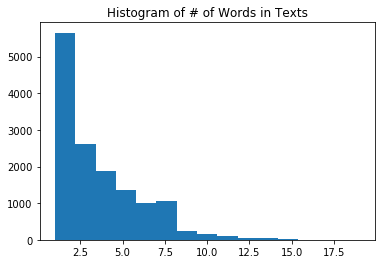

In [14]:
# Plot histogram of text lengths
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 20]
plt.hist(text_lengths, bins=15)
plt.title('Histogram of # of Words in Texts')
plt.show()

In [17]:
# Choose max text word length at 17
sentence_size = 17
min_word_freq = 3

In [18]:
# Setup vocabulary processor
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size, min_frequency=min_word_freq)

# Have to fit transform to get length of unique words.
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)

In [19]:
#define the target variable
target = pd.DataFrame(cleaned['Genre'])

In [20]:
#use categorical processor in order to convert the catergorical variables in an integer
#form that could be manipulated by tensorflow
from tensorflow.contrib import learn as skflow
cat_processor = skflow.preprocessing.CategoricalProcessor()
target = np.array(list(cat_processor.fit_transform(target)))
target

array([[ 1],
       [ 2],
       [ 3],
       ..., 
       [11],
       [ 5],
       [21]], dtype=int64)

In [21]:
#SET random seed to get the same random results every time for tf AND np
npRandom = np.random.seed(seed=12345)
tfRandom = tf.set_random_seed(12)

In [22]:
# Split up data set into train/test
npRandom
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [24]:
# Start a graph session
sess = tf.Session()

In [25]:
# Setup Index Matrix for one-hot-encoding
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

# Create variables for logistic regression
tfRandom
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
tfRandom
b = tf.Variable(tf.random_normal(shape=[1,1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1, 1,1], dtype=tf.float32)

In [26]:
# Text-Vocab Embedding
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

# Declare model operations
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)




In [27]:
# Declare loss function (Cross Entropy loss)
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))
loss = tf.reduce_mean(losses.categorical_crossentropy(model_output, y_target))

# Prediction operation
prediction = tf.tanh(model_output)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.00+1)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [28]:
# Start Logistic Regression
print('Starting Training Over {} Sentences.'.format(len(texts_train)))
loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    
    
    sess.run(train_step, feed_dict={x_data: t, y_target: y_data})
    temp_loss = sess.run(loss, feed_dict={x_data: t, y_target: y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1)%100==0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
        
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Starting Training Over 11355 Sentences.
Training Observation #100: Loss = 3.31571e-08
Training Observation #200: Loss = -4.87156e-07
Training Observation #300: Loss = -6.78932e-07
Training Observation #400: Loss = -4.19967e-08
Training Observation #500: Loss = -3.60244e-07
Training Observation #600: Loss = 2.39504e-07
Training Observation #700: Loss = -4.99578e-07
Training Observation #800: Loss = -3.81888e-07
Training Observation #900: Loss = 5.8998e-07
Training Observation #1000: Loss = -2.18143e-07
Training Observation #1100: Loss = -7.70927e-07
Training Observation #1200: Loss = 3.21806e-07
Training Observation #1300: Loss = -2.3117e-07
Training Observation #1400: Loss = -8.1457e-07
Training Observation #1500: Loss = -6.5452e-07
Training Observation #1600: Loss = -3.71722e-07
Training Observation #1700: Loss = 3.40489e-07
Training Observation #1800: Loss = 2.86543e-07
Training Observation #1900: Loss = -4.15346e-07
Training Observation #2000: Loss = 1.81412e-07
Training Observation

In [29]:
# Get test set accuracy
print('Getting Test Set Accuracy For {} Sentences.'.format(len(texts_test)))
test_acc_all = []
test_acc_avg = []
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    
    if (ix+1)%50==0:
        print('Test Observation #' + str(ix+1))    
    
    # Keep trailing average of past 50 observations accuracy
    # Get prediction of single observation
    [[temp_pred]] = sess.run(prediction, feed_dict={x_data:t, y_target:y_data})
    # Get True/False if prediction is accurate
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)
    #for plot
    if len(test_acc_all) >= 50:
        test_acc_avg.append(np.mean(test_acc_all[-50:]))

print('\nOverall Test Accuracy: {}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy For 2839 Sentences.
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100
Test Observation #1150
Test Observation #1200
Test Observation #1250
Test Observation #1300
Test Observation #1350
Test Observation #1400
Test Observation #1450
Test Observation #1500
Test Observation #1550
Test Observation #1600
Test Observation #1650
Test Observation #1700
Test Observation #1750
Test Observation #1800
Test Observation #1850
Test Observation #1900
Test Observation #1950
Test Observation #2000
Test Observation #2050
Test Observation #2100
Test Obs

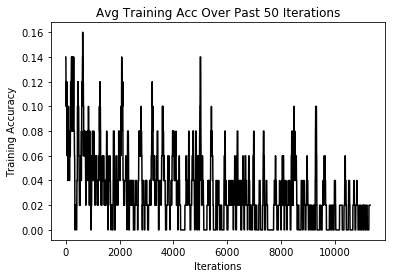

In [30]:
# Plot training accuracy over time
plt.plot(range(len(train_acc_avg)), train_acc_avg, 'k-', label='Train Accuracy')
plt.title('Avg Training Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.show()

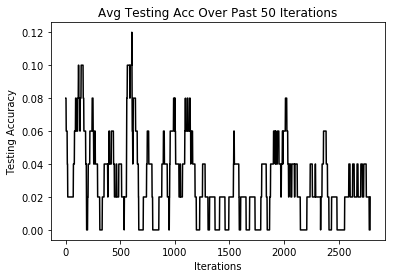

In [31]:
# Plot testing accuracy over time
plt.plot(range(len(test_acc_avg)), test_acc_avg, 'k-', label='Test Accuracy')
plt.title('Avg Testing Acc Over Past 50 Iterations')
plt.xlabel('Iterations')
plt.ylabel('Testing Accuracy')
plt.show()